# Predicting house location in California based on house value and income
### **Goal:** 
#### Build a supervised classification model using logistic regression to predict whether a house is near or far from the ocean based on income and house value. 
Dataset: [California Housing Dataset (1990 Census)](https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [18]:
# Importing the data in a dataframe

df = pd.read_csv("https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv")

In [17]:
# Let's first have a look at the data structure. Each row represents a Block Group, 
# which is the smallest geographical unit used by the U.S. Census Bureau (few hundred households).

print(df.head)

<bound method NDFrame.head of        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  ho

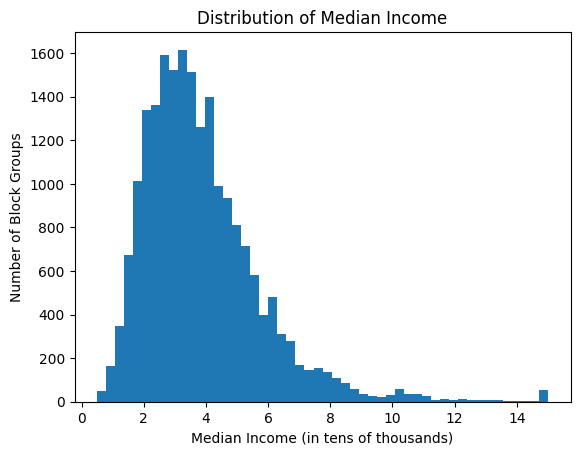

In [16]:
# We want to have a look at how the data for the median income is distributed

plt.hist(df["median_income"], bins=50)
plt.xlabel("Median Income (in tens of thousands)")  
plt.ylabel("Number of Block Groups")                    
plt.title("Distribution of Median Income")       
plt.show()

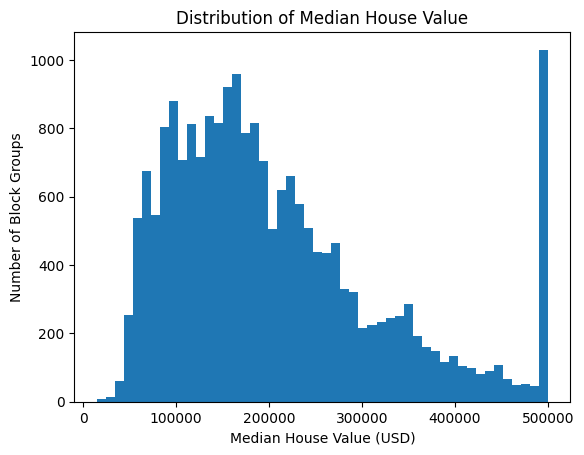

In [15]:
# There seem to be a few outliers above. We will have to see later if they affect the model's accuracy by a lot. 
# Let's also look at the distribution for the median house value.

plt.hist(df["median_house_value"], bins=50)
plt.xlabel("Median House Value (USD)")  
plt.ylabel("Number of Block Groups")                    
plt.title("Distribution of Median House Value")       
plt.show()

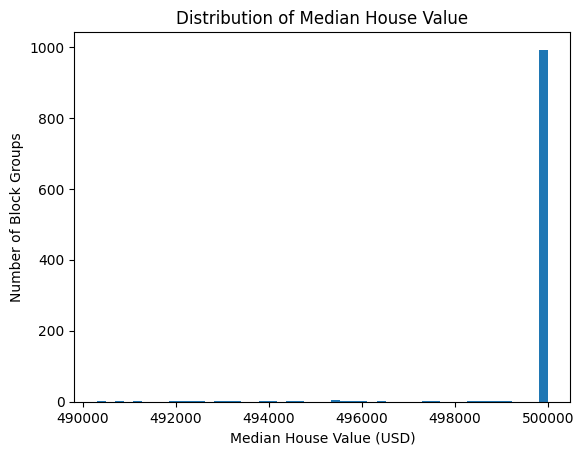

In [19]:
# There is an artificial spike at 500000, probably because house values are capped at that price 
# and all houses with greater value are shown as having value of 500000. 

plt.hist(df[df["median_house_value"] > 490000]["median_house_value"], bins=50)
plt.xlabel("Median House Value (USD)")  
plt.ylabel("Number of Block Groups")                    
plt.title("Distribution of Median House Value")       
plt.show()

### Let's try to get an idea of the distribution these expensive houses follow in terms of location.
We see below that compared to the distribution of house locations for the total population, *there is a much lower percentage of these expensive houses found inland*.

In [20]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [21]:
df[df["median_house_value"] > 490000]['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     565
NEAR OCEAN    230
NEAR BAY      208
INLAND         28
Name: count, dtype: int64

These expensive homes seem to be mostly found within 1 hour from the ocean. This is a significant chunk of data both in *size* as well as in *distribution*, hence I will not manipulate it at this point before training the model.

In [23]:
# Looking to see if the data has any null values which we will need to address before using the data.
# In this case all the null values are for total_bedrooms which we don't really care about.

df.apply(lambda x: sum(x.isnull()), axis=0)

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [26]:
# Now defining the variables that will be used for model training and testing.

x = df.iloc[:, [7, 8]].values
y = df.iloc[:, [9]].values.ravel()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

In [25]:
# Training the model for Multi-class classification. Here I am using many iterations because I want to make sure
# that the model can converge for our 5 categories.

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver = 'lbfgs', max_iter=5000)
clf.fit(x_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,5000
,multi_class,'deprecated'


In [27]:
# Using the model to make predicitons.

y_pred = clf.predict(x_test)
y_pred

array(['INLAND', '<1H OCEAN', '<1H OCEAN', ..., '<1H OCEAN', '<1H OCEAN',
       '<1H OCEAN'], shape=(5160,), dtype=object)

In [28]:
# Testing our predictions and model accuracy using a confusion matrix.

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[1894,  388,    0,    0,    0],
       [ 355, 1308,    0,    0,    0],
       [   2,    0,    0,    0,    0],
       [ 463,  106,    0,    0,    0],
       [ 498,  146,    0,    0,    0]])

## Evaluation of Results

The confusion matrix clearly shows that the model's predictions were skewed due to the improportional availability of data for each category under consideration.

In order to account for this feature of the dataset we need to further bin the data, so that all categories are adequately represented. We will now only use 2 categories, splitting the houses into those close and far from the ocean. The 'ISLAND' entries will be removed.

In [29]:
# Removing 'ISLAND' entries and further binning the data.

df = df[df['ocean_proximity'] != 'ISLAND'].copy()

df.loc[:, 'ocean_proximity_bin'] = df['ocean_proximity'].replace({
    '<1H OCEAN': 'close',
    'NEAR OCEAN': 'close',
    'NEAR BAY': 'close',
    'INLAND': 'far'
})

print(df['ocean_proximity_bin'].value_counts())


ocean_proximity_bin
close    14084
far       6551
Name: count, dtype: int64


In [30]:
# Re-defining our variables and defining the test size.

x2 = df.iloc[:, [7, 8]].values
y2 = df.iloc[:, [10]].values.ravel()
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size = 0.25, random_state = 0)

In [31]:
# Training the model for Binary Classification.

clf2 = LogisticRegression(random_state = 0)
clf2.fit(x2_train, y2_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [32]:
# Making predictions.

y2_pred = clf2.predict(x2_test)
y2_pred

array(['close', 'far', 'close', ..., 'close', 'close', 'close'],
      shape=(5159,), dtype=object)

In [33]:
# Assessing the model's predictions using a confusion matrix.

cm2 = confusion_matrix(y2_test, y2_pred)
cm2

array([[3120,  389],
       [ 494, 1156]])

In [38]:
# The value on the right is the value considered positive by the confusion matrix.

classes = np.unique(y2_test)
print(classes)

['close' 'far']


In [39]:
# We therefore have the following results:

TN, FP, FN, TP = cm2.ravel()
print(f' True Negatives: {TN}')
print(f' False Positives: {FP}')
print(f' False Negatives: {FN}')
print(f' True Positives: {TP}')

 True Negatives: 3120
 False Positives: 389
 False Negatives: 494
 True Positives: 1156


In [42]:
# Using the results from the confusion matrix, the accuracy and precision of the model are determined.

acc = (TN+TP)/(TN+TP+FN+FP)
pre = TP/(FP+TP)

print(f"Accuracy: {acc}, Precision: {pre}")

Accuracy: 0.8288427989920527, Precision: 0.7482200647249191


## Interpretation

For Binary Classification the accuracy of the model is satisfactory at 0.83, indicating that the degree to which the data was handled was adequate for this purpose after all.